# Atividade Final: Machine Learning

O Grande Rei de Lumi convocou uma reunião do Conselho Real a fim de discutir o futuro da saúde pública de seu reino. Diana Didatolov, que estava presente, mostrou os dados coletados pela Organização Mística da Saúde (OMS) e arquivados na Biblioteca Real, os quais continham informações preciosas a respeito da saúde pública das várias regiões de Lumi nos últimos anos. O rei, que se preocupava muito com a qualidade de vida de seus anciãos, desejava prever a futura expectativa de vida das diversas regiões do reino. O que Diana não sabia, no entanto, era como obter tal informação a partir de uma coleção de dados tão extensa.

Diante desse problema, o Grande Rei convocou a guilda mais poderosa de Lumi, composta por dois bravos cavaleiros e duas magas poderosas: Os Guardiões de Ba'IA. 

Os Cavaleiros Maria e Izaque, que possuem muitos contatos através do reino, decidiram perguntar aos sábios do Clã Vizin'Hos qual seria a solução do problema.

A Maga Dara, por outro lado, achou mais sábio perguntar à grande Árvore do Conhecimento a resposta.

Já a Feiticeira Alice, não satisfeita, viajou até a Floresta da Elucidação em busca de uma maneira de ajudar o Rei. 

Alice, Izaque, Maria e Dara retornaram com respostas diferentes a respeito da expectativa de vida de cada região. Mas como saber qual desses métodos se aproximou mais da realidade? 

_Descrição do Projeto: Comparar diversos modelos de previsão (KNN-vizinhos, Árvore de Decisão e Floresta de Decisão) e métodos de tratamento de dados quanto a sua eficiência na predição._

## Começando com o que realmente importa

Iniciamos importando todas as bibliotecas, módulos e funções que serão utilizadas nesse notebook.

In [1]:
import pandas as pd
import numpy as np
import statistics as st
import optuna
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from optuna import create_study, Trial

# Tratamento de Dados

Quando adentramos a biblioteca real e vimos o imenso pergaminho que Diana nos entregou, logo soubemos que teríamos um imenso trabalho pela frente para tratar todos aqueles dados, depois de uma análise minuciosa das diferentes formas de abordar esse problema, portanto, ao longo desse tratamento, criaremos diferentes versões do data frame e, ao final, usaremos cada um deles para treinar diferentes modelos. Por fim, iremos avaliar e comparar a eficiência de cada um desses modelos na predição. <br>

## Primeiros Passos

Primeiro vamos salvar nosso dataframe numa variável, assim como obter algumas informações básicas sobre ele, como número de linhas e colunas. 

In [2]:
raw_df = pd.read_csv('life_expect.csv') #salvar o dataframe na variável 'raw_df'
print(raw_df) #mostrar o dataframe
print(raw_df.columns) #mostrar as colunas do dataframe

          Country  Year      Status  Life expectancy   Adult Mortality  \
0     Afghanistan  2015  Developing              65.0            263.0   
1     Afghanistan  2014  Developing              59.9            271.0   
2     Afghanistan  2013  Developing              59.9            268.0   
3     Afghanistan  2012  Developing              59.5            272.0   
4     Afghanistan  2011  Developing              59.2            275.0   
...           ...   ...         ...               ...              ...   
2933     Zimbabwe  2004  Developing              44.3            723.0   
2934     Zimbabwe  2003  Developing              44.5            715.0   
2935     Zimbabwe  2002  Developing              44.8             73.0   
2936     Zimbabwe  2001  Developing              45.3            686.0   
2937     Zimbabwe  2000  Developing              46.0            665.0   

      infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   \
0                62     0.01    

In [3]:
print('O dataset possui', raw_df.shape[0], 'instâncias e', raw_df.shape[1], 'atributos.')

O dataset possui 2938 instâncias e 22 atributos.


Nosso dataset possui dados em diferentes unidades: alguns estão em anos, porcentagem, unidade por milhar, etc. Para nos guiar a respeito da unidade utilizada em cada coluna, criamos um dicionário abaixo.

In [4]:
#Explicação de cada coluna segundo o Kaggle
info_colunas = {
    'Country' : {'Country'},
    'Year' : {'Year of the data'},
    'Status' : {'developing or developed country?'},
    'Life expectancy' : {'Life Expectancy in age'},
    'Adult Mortality' : {'Adult Mortality Rates of both sexes (probability of dying between 15 and 60 years per 1000 population) '},
    'infant deaths' : {'Number of Infant Deaths per 1000 population'},
    'Alcohol' : {'Alcohol, recorded per capita (15+) consumption (in litres of pure alcohol)'},
    'percentage expenditure' : {'Expenditure on health as a percentage of Gross Domestic Product per capita(%) '},
    'Hepatitis B' : {'Hepatitis B (HepB) immunization coverage among 1-year-olds (%)'},
    'Measles ' : {'Measles - number of reported cases per 1000 population '},
    ' BMI ' : {'Average Body Mass Index of entire population '},
    'under-five deaths ' : {'Number of under-five deaths per 1000 population'},
    'Polio' : {'Polio (Pol3) immunization coverage among 1-year-olds (%) '},
    'Total expenditure' : {'General government expenditure on health as a percentage of total government expenditure (%)'},
    'Diphtheria ' : {'Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%) '},
    ' HIV/AIDS' : {'Deaths per 1 000 live births HIV/AIDS (0-4 years) '},
    'GDP' : {'Gross Domestic Product per capita (in USD)'},
    'Population' : {'Population of the country '},
    ' thinness  1-19 years' : {'Prevalence of thinness among children and adolescents for Age 10 to 19 (% ) '},
    ' thinness 5-9 years' : {'Prevalence of thinness among children for Age 5 to 9(%) '},
    'Income composition of resources' : {'Human Development Index in terms of income composition of resources (index ranging from 0 to 1) '},
    'Schooling' : {'Number of years of Schooling(years) '}
    }

Decidimos que os dados contidos nas colunas "Country" e "Year" não serão úteis para a nossa análise, de forma que eles serão removidos do dataset. Verificamos, também, que há uma coluna contendendo dados em string a respeito do status de desenvolvimento de cada país (em que as opções possíveis são 'desenvolvido' e 'em desenvolvimento'). Aplicaremos um método de mapeamento para transformar esses valores em string em valores booleanos 0 e 1. 

In [5]:
raw_1_df = raw_df.drop( #armazenamos na variável 'raw_1_df' o dataframe sem as colunas 'country' e 'year'
    ["Country", 'Year'], axis=1)
#print(raw_1_df)

In [6]:
#define um dicionário que determina pelo que cada valor deve ser substituido na série
mapear_status = {'Developing' : 1, 'Developed' : 0} 

#cria uma copia do df onde será realizada a iteração
raw_copy_df = raw_1_df.copy()
#print(raw_copy_df.copy)

#Realiza o mapeamento
raw_1_df['Status'] = raw_copy_df['Status'].map(mapear_status, na_action=None)

print(raw_1_df)

      Status  Life expectancy   Adult Mortality  infant deaths  Alcohol  \
0          1              65.0            263.0             62     0.01   
1          1              59.9            271.0             64     0.01   
2          1              59.9            268.0             66     0.01   
3          1              59.5            272.0             69     0.01   
4          1              59.2            275.0             71     0.01   
...      ...               ...              ...            ...      ...   
2933       1              44.3            723.0             27     4.36   
2934       1              44.5            715.0             26     4.06   
2935       1              44.8             73.0             25     4.43   
2936       1              45.3            686.0             25     1.72   
2937       1              46.0            665.0             24     1.68   

      percentage expenditure  Hepatitis B  Measles    BMI   \
0                  71.279624         

Pronto! Agora que nosso dataframe possui apenas as colunas que utilizaremos para a nossa predição e todos os dados estão em formato número, podemos prosseguir com o tratamento dos dados. 

# Dados NaN

No tratamendo de Dados, existem diferentes formas de se lidar com dados NaN. Aqui, iremos comparar 3 métodos diferentes: <br>

1. Preencher os dados NaN com a mediana <br>
2. Excluir todas as linhas contendo pelo menos um dado NaN <br>
3. Excluir colunas com grande volume de dados NaN e só então excluir as linhas contendo pelo menos um dado NaN <br>
<br>

<font size = 1.6>Letrinhas miúdas: Entendemos que essas não são as únicas formas possíveis de se tratar dados NaN, sendo possível até mesmo unir as técnicas acima. No entanto, elencamos 3 opções a fim de compará-las e determinar a melhor estratégia para o nosso conjunto de dados. 


Primeiro, vamos iniciar utilizando o método `.info()` para saber se o nosso dataset possui dados NaN e se há colunas específicas com um maior número de dados NaN.

In [7]:
raw_1_df.info() #Obtém informações quanto ao número de valores não nulos no dataframe original

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Status                           2938 non-null   int64  
 1   Life expectancy                  2928 non-null   float64
 2   Adult Mortality                  2928 non-null   float64
 3   infant deaths                    2938 non-null   int64  
 4   Alcohol                          2744 non-null   float64
 5   percentage expenditure           2938 non-null   float64
 6   Hepatitis B                      2385 non-null   float64
 7   Measles                          2938 non-null   int64  
 8    BMI                             2904 non-null   float64
 9   under-five deaths                2938 non-null   int64  
 10  Polio                            2919 non-null   float64
 11  Total expenditure                2712 non-null   float64
 12  Diphtheria          

Observamos que as colunas 'Alcohol', 'Life expectancy', 'Adult Mortality', 'Hepatitis B', 'BMI', 'Polio', 'Total expenditure', 'Diphtheria', 'GDP', 'Population', 'thinness  1-19 years','thinness 5-9 years','Income composition of resources' e 'Schooling' possuem dados NaN, sendo as colunas `Population`, `GDP` e `Hepatites B` aquelas com o maior número de dados NaN. <br>
A partir do dataset original, vamos criar 3 novos datasets, cada um utilizando um dos métodos de se lidar com dados NaN mencionados acima. Os datasets serão nomeados a partir das letras gregas alpha, beta e gamma e serão futuramente comparados a fim de verificar qual leva a uma melhor acurácia na predição.  

## Método 1: Remover todas as linhas contendo dados NaN (Alpha)

In [8]:
alpha_df = raw_1_df.dropna() #armazenamos na variável 'alpha_df' o dataframe sem as linhas com valores NaN
#print(alpha_df)
print('Após remover as linhas com dados faltantes, obtivemos um dataset com', 
      alpha_df.shape[0], 'instâncias e', alpha_df.shape[1], 'atributos.')

Após remover as linhas com dados faltantes, obtivemos um dataset com 1649 instâncias e 20 atributos.


## Método 2: Preencher linhas contendo dados NaN utilizando a mediana (Beta)

Para preencher as linhas contendo dados NaN utilizaremos o método `Simple Imputer` do Sklearn e a estratégia de preenchimento `mediana`. Como temos uma coluna de dados booleanos 0 e 1 ('Status'), não podemos utilizar essa estratégia sobre esses dados, afinal seria imputado um valor entre 0 e 1! Nesse caso, teríamos que aplicar a estratégia `mode` nessa coluna. No entanto, nossa coluna 'Status' não possui nenhum dado NaN, de forma que não seja necessário usar nenhum método de imputamento sobre ela. 

In [9]:
beta_df = raw_1_df #criamos uma cópia do dataset original

#Definir em quais colunas desejamos preencher os dados NaN faltantes
colunas = ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

#Define o método de imputamento e a estratégia
imputer = SimpleImputer(missing_values = np.nan, 
                        strategy ='mean')

#Fita os dados sobre as colunas que desejamos imputar
imputer = imputer.fit(raw_1_df[colunas])

#Cria um novo dataset com as colunas preenchidas pela mediana!
beta_df[colunas] = imputer.transform(raw_1_df[colunas])

In [10]:
#print(beta_df)
#beta_df.info()

## Método 3: Excluir colunas com grande volume de dados NaN (Gamma)

Por fim, iremos criar um terceiro dataset a partir de uma técnica onde identificamos colunas com um grande número de valores NaN e as removemos. Só então removemos as linhas contendo pelo menos um dado NaN. Para isso, iremos remover as colunas `Hepatitis B, Population e GDP`. 

In [11]:
#armazenamos na variável 'df_semcolunas_nan' o dataframe sem as colunas com muitos valores nan e as colunas país e ano
df_semcolunas_nan = raw_1_df.drop(
    ['Hepatitis B', 'Population', 'GDP'], axis=1)
#print(df_semcolunas_nan)


#armazenamos na variável 'final_df_semcolunas_nan' o dataframe sem as linhas com valores NaN
gamma_df = df_semcolunas_nan.dropna()
print('Após remover as linhas com dados faltantes, obtivemos um dataset com', 
      gamma_df.shape[0], 'instâncias e', gamma_df.shape[1], 'atributos.')

Após remover as linhas com dados faltantes, obtivemos um dataset com 2928 instâncias e 17 atributos.


Pronto, agora temos 3 datasets criados a partir de diferentes métodos de tratamento de dados NaN! Cada um desses Datasets possui 0 valores NaN, deixando-os prontos para a próxima fase do tratamento de dados. 

# Normalização

Utilizaremos 3 modelos de Machine Learning com os nossos dados: KNN-Vizinhos, Árvore de Decisão e Floresta de Decisão. Modelos KNN realizam sua previsão com base na distância entre os dados, de forma que colunas contendo dados com dimensões muito maiores que as outras podem apresentar um peso maior na decisão que não se reflete na realidade do problema. Por isso, é recomendável realizar uma normalização dos dados antes de prosseguir. <br>

Para verificar a influência da normalização (ou a falta dela) nos dados, iremos comparar também a eficiência dos nossos modelos. Espera-se que seja percebida alguma diferença na predição com o modelo KNN e nenhuma (ou pouca, dada a aleatoriedade inerente a esses modelos) diferença para os modelos árvore e floresta de decisão. <br>

Optamos por comparar criar duas versões para cada um dos datasets já criados anteriormente: <br>

a. Versão sem normalizar <br>
b. Versão utilizando Normalização Padrão <br> 

Assim teremos 6 datasets finais:

1. alpha_df
2. beta_df
3. gamma_df
4. beta_norm_df
5. gamma_df
6. gamma_norm_df


In [12]:
#Lista com as colunas onde será realizada a normalização.
Colunas = ['Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

#Como o dataframe gamma possui menos colunas que as outras, criamos uma lista separada
Colunas_gamma = ['Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

#Cria cópias de cada um dos 3 datasets
norm_alpha_df = alpha_df.copy()
norm_beta_df = beta_df.copy()
norm_gamma_df = gamma_df.copy()

#Define o método de normalização que será utilizado
normalizador = StandardScaler()

#Fita os dados das colunas desejadas 
#Realiza a normalização sobre os dados Alpha
normalizador.fit(alpha_df[Colunas])
norm_alpha_df[Colunas] = normalizador.transform(alpha_df[Colunas])

#Fita os dados das colunas desejadas 
#Realiza a normalização sobre os dados Beta
normalizador.fit(beta_df[Colunas])
norm_beta_df[Colunas] = normalizador.transform(beta_df[Colunas])

#Fita os dados das colunas desejadas 
#Realiza a normalização sobre os dados Gamma
normalizador.fit(gamma_df[Colunas_gamma])
norm_gamma_df[Colunas_gamma] = normalizador.transform(gamma_df[Colunas_gamma])

Pronto, agora nossos dados estão todos normalizados, tratados e prontos para seguir para o próximo passo!

# Redução de Dimensionalidade: Aprendizado não supervisionado

Como foram realizadas estratégias diferentes para tratar os dados, vamos realizar três métodos de PCA, um para cada novo dataframe resultante da etapa `Tratamento de Dados`. Porém, faremos a redução da dimensionalidade para todos os datasets, pois temos um número muito grande de atributos.

#### Reduzindo dimensionalidade do dataset `norm_alpha_df`

In [13]:
#Separando target dos atributos
norm_alpha_df

y_alpha_norm = norm_alpha_df['Life expectancy ']
X_alpha_norm = norm_alpha_df.drop(['Life expectancy '], axis = 1)

X_alpha_norm

,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,1,0.756629,0.243745,-1.122948,-0.356909,-0.555446,-0.106171,-0.963560,0.238134,-3.455955,0.958840,-0.887941,-0.312389,-0.434239,0.270913,2.685909,2.663654,-0.833462,-0.722799
1,1,0.820490,0.260300,-1.122948,-0.355633,-0.672648,-0.171828,-0.988878,0.256557,-1.139051,0.967541,-1.027006,-0.312389,-0.431760,-0.203382,2.751157,2.706643,-0.849853,-0.758583
2,1,0.796542,0.276854,-1.122948,-0.355806,-0.594514,-0.177977,-1.014197,0.274979,-0.960828,0.945790,-0.934296,-0.312389,-0.430100,0.242452,2.794656,2.749632,-0.882634,-0.794367
3,1,0.828472,0.301687,-1.122948,-0.352983,-0.477312,0.055789,-1.039516,0.299541,-0.738049,1.115452,-0.795231,-0.312389,-0.426769,-0.155548,2.838155,2.814116,-0.920878,-0.830151
4,1,0.852420,0.318242,-1.122948,-0.393403,-0.438245,0.078203,-1.059771,0.324104,-0.693493,0.832682,-0.748876,-0.312389,-0.479628,-0.165747,2.903403,2.857105,-0.970049,-0.937503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,1,4.428626,-0.045965,-0.042998,-0.397439,-0.438245,-0.217549,-0.558461,-0.013633,-0.738049,0.510759,-0.887941,5.242678,-0.445561,-0.026635,0.989458,0.965586,-1.226833,-1.044856
2934,1,4.364766,-0.054242,-0.117478,-0.397439,-2.821346,-0.121643,-0.578715,-0.019774,-3.411399,0.245390,-0.748876,5.756729,-0.445650,-0.028673,1.076455,1.073058,-1.166735,-0.937503
2935,1,-0.760066,-0.062520,-0.025620,-0.397439,-0.242909,-0.190473,-0.598970,-0.025914,-0.470714,0.249740,-0.609811,6.270780,-0.480168,-0.206251,-0.793991,-0.775472,-1.117564,-0.758583
2936,1,4.133270,-0.062520,-0.698416,-0.397439,-0.125707,-0.168158,-0.619225,-0.032055,-0.337046,0.088779,-0.424391,6.652173,-0.437348,-0.032474,-0.706993,-0.689494,-1.117564,-0.830151


In [14]:
#centralizando os dados pela média [2]

medias = X_alpha_norm.mean(axis=0)

X_alpha_norm_centralizado = X_alpha_norm - medias

Para facilitar o trabalho que seria repetitivo, criei a função denominada de `variancia_explicada` para que ela faça todo o processo de calcular os autovalores e autovetores, além de gerar o gráfico de variância explicada para vizualizar em qual faixa de atributos teríamos uma grande perca de dados do dataset.

In [15]:
#computando o PCA com o PCA do scikite learn
#os códigos abaixo são baseados no notebook do professor Daniel Roberto Cassar [2]

from sklearn.decomposition import PCA

def variancia_explicada (X):
    """
    Essa função calcula os autovalores, autovetores e a variância explicada de um dataset. 
       Ela também plota gráficos da variância explicada.

        Inputs:
        X: dataset que não contém o target.

        Returns:
        Retorna os autovalores e autovetores do dataset.
    """
    pca = PCA()

    pca.fit(X)

    autovalores = pca.explained_variance_
    autovetores = pca.components_.T

    variancia_explicada = pca.explained_variance_ratio_

    #print(f'autovalores_{dataset_name}: \n{autovalores}')
    #print()
    #print(f'autovetores_{dataset_name}: \n {autovetores}')

    id_componentes = np.arange(1, pca.n_components_ + 1)

    figura, eixo = plt.subplots(1, 2)

    # Plot variância explicada
    eixo[0].bar(id_componentes, variancia_explicada)
    eixo[0].set(xlabel="Componente", title="Variância explicada", ylim=(0.0, 1.0))

    # Plot variância acumulada
    cv = np.cumsum(pca.explained_variance_ratio_)
    eixo[1].plot(np.r_[0, id_componentes], np.r_[0, cv], marker="o")
    eixo[1].set(
        xlabel="Número de componentes",
        title="Variância acumulada",
        ylim=(0.0, 1.0),
    )
    eixo[1].axhline(0.9, linestyle="--", color="red")
    eixo[1].axvline(9, linestyle="--", color="black", label ='9 PC"s')
    eixo[1].axvline(8, linestyle="--", color="purple", label ='8 PC"s')
    eixo[1].axvline(10, linestyle="--", color="orange", label ='10 PC"s')
    eixo[1].axvline(11, linestyle="--", color="green", label ='11 PC"s')
    eixo[1].legend(title='Número de PC"s', loc=3)
    figura.set(figwidth=8)
    
    return autovalores, autovetores

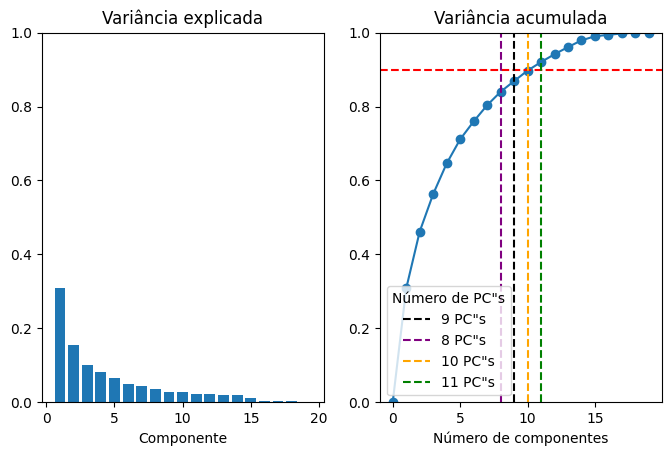

In [16]:
autovalores_alpha_norm, autovetores_alpha_norm = variancia_explicada(X_alpha_norm)

A partir dos gráficos observados acima, podemos concluir que para o dataset `norm_alpha_df` são necessárias 10 componentes principais para obter toda a informação do dataset. A redução de dimensionalidade caiu de 17 colunas para 10 colunas.

In [17]:
#montando a matriz loading [2]
matriz_alpha_norm_loading = autovetores_alpha_norm

feature_names = X_alpha_norm.columns

nomes_componentes = [f"PC{i+1}" for i in range(X_alpha_norm.shape[1])]

df_matriz_loading_alpha_norm = pd.DataFrame(
    matriz_alpha_norm_loading,
    columns=nomes_componentes,
    index=feature_names,
)

df_matriz_loading_alpha_norm

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
Status,0.080601,-0.058176,-0.024664,-0.047912,-0.000315,-0.007469,0.036511,0.052896,0.037825,0.078488,0.045829,0.063908,-0.063039,0.035767,-0.004884,0.307890,-0.931459,0.039504,-0.001237
Adult Mortality,0.200249,-0.193935,0.050235,0.400723,-0.356375,0.198670,-0.004125,0.168550,-0.045849,-0.178097,-0.330255,0.605193,-0.170271,0.154180,0.021406,-0.028674,0.031406,-0.007005,-0.007855
infant deaths,0.236225,0.458934,-0.034020,-0.045720,-0.123412,-0.032446,0.019776,0.098068,-0.018396,-0.061749,-0.129975,-0.218645,-0.286031,0.191335,0.069133,0.003667,0.002705,-0.003056,-0.715511
Alcohol,-0.260424,0.185848,0.084259,0.185658,-0.257268,0.132921,-0.248550,-0.320721,-0.310684,-0.379487,-0.326417,-0.243079,0.237486,-0.312863,-0.133873,0.048990,-0.163038,0.007672,-0.012746
percentage expenditure,-0.228350,0.228431,0.262320,0.389411,0.341320,0.050823,0.201866,0.154444,0.053566,0.029863,-0.021181,0.010108,-0.005915,-0.006335,-0.011219,0.036470,-0.057682,-0.694525,-0.001329
Hepatitis B,-0.152730,-0.065401,-0.525144,0.111518,0.024053,-0.002069,0.134562,0.201965,0.373322,-0.537844,0.019359,-0.155122,0.281703,0.300967,-0.024720,0.016237,-0.026508,-0.010292,-0.000973
Measles,0.133218,0.314926,-0.041453,-0.105098,-0.197026,0.229196,0.590512,-0.469066,0.286460,0.079471,0.021542,0.228236,0.224111,-0.136438,-0.011857,0.003252,0.008841,-0.000423,0.015235
BMI,-0.279060,0.061785,0.078902,-0.238359,-0.203890,-0.039374,-0.156217,0.330164,0.568692,0.249966,-0.459984,0.001763,0.001093,-0.273170,-0.079026,0.014550,0.011706,0.005370,0.002665
under-five deaths,0.239566,0.451170,-0.021743,-0.037152,-0.128075,-0.033519,0.013420,0.100352,-0.029407,-0.078790,-0.151735,-0.238055,-0.299002,0.202499,0.070652,-0.008439,-0.006335,-0.004784,0.697942
Polio,-0.188733,0.054568,-0.484096,0.131546,-0.003088,0.076796,0.053456,-0.019627,-0.333552,0.593010,-0.323718,-0.032303,0.201819,0.296913,-0.048918,0.020053,0.009243,-0.007993,0.003378


#### Reduzindo dimensionalidade do dataset: `norm_beta_df`

In [18]:
X_beta_norm = norm_beta_df.drop(['Life expectancy '], axis=1)
y_beta_norm = norm_beta_df['Life expectancy ']

norm_beta_df

,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,1,65.0,0.791586,0.268824,-1.172958,-0.335570,-0.705861,-0.110384,-0.964715,0.255359,-3.278638,0.925806,-0.732952,-0.323445,-0.525248,0.389975,2.813130,2.773279,-0.725401,-0.579931
1,1,59.9,0.856072,0.285786,-1.172958,-0.334441,-0.838704,-0.168124,-0.989810,0.274060,-1.051482,0.934140,-0.859877,-0.323445,-0.523083,-0.230936,2.881408,2.817902,-0.740050,-0.610570
2,1,59.9,0.831890,0.302749,-1.172958,-0.334594,-0.750142,-0.173531,-1.014905,0.292761,-0.880163,0.913306,-0.775260,-0.323445,-0.521632,0.352715,2.926927,2.862526,-0.769349,-0.641209
3,1,59.5,0.864132,0.328193,-1.172958,-0.332096,-0.617299,0.032045,-1.040000,0.317696,-0.666013,1.075815,-0.648335,-0.323445,-0.518723,-0.168315,2.972446,2.929461,-0.803531,-0.671847
4,1,59.2,0.888314,0.345155,-1.172958,-0.367862,-0.573018,0.051757,-1.060076,0.342631,-0.623183,0.804966,-0.606027,-0.323445,-0.564893,-0.181666,3.040724,2.974085,-0.847480,-0.763764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,1,44.3,4.499494,-0.028022,-0.062024,-0.371433,-0.573018,-0.208332,-0.563194,-0.000223,-0.666013,0.496616,-0.732952,6.275044,-0.535137,0.000449,1.037896,1.010651,-1.076989,-0.855681
2934,1,44.5,4.435009,-0.036503,-0.138640,-0.371433,-3.274163,-0.123991,-0.583270,-0.006456,-3.235808,0.242435,-0.606027,6.885650,-0.535214,-0.002221,1.128934,1.122210,-1.023274,-0.763764
2935,1,44.8,-0.739941,-0.044984,-0.044146,-0.371433,-0.351612,-0.184521,-0.603346,-0.012690,-0.409034,0.246602,-0.479102,7.496256,-0.565364,-0.234691,-0.828375,-0.796600,-0.979326,-0.610570
2936,1,45.3,4.201249,-0.044984,-0.736246,-0.371433,-0.218769,-0.164897,-0.623422,-0.018924,-0.280544,0.092426,-0.309869,7.949287,-0.527964,-0.007196,-0.737337,-0.707353,-0.979326,-0.671847


In [19]:
#Centralizando os dados pela média

medias_beta = X_beta_norm.mean()
X_beta__norm_centralizado = X_beta_norm - medias_beta

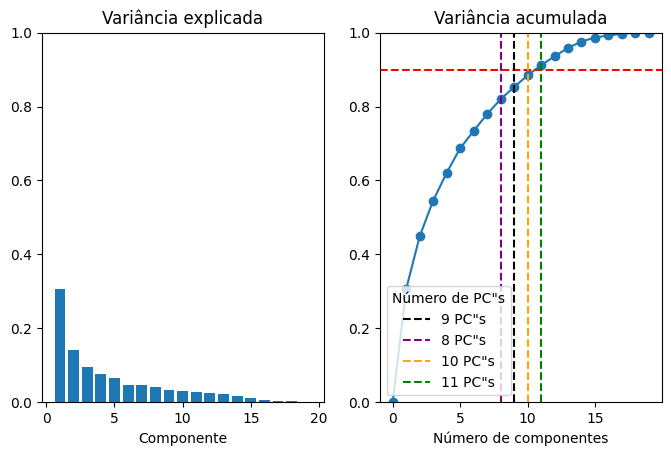

In [20]:
autovalores_beta_norm, autovetores_beta_norm = variancia_explicada(X_beta_norm)

Ao contrário do observado no dataset anterior, este dataset necessita de <b>11 componentes principais</b> para que tenhamos todas as informações necessárias do dataset.

In [21]:
#montando a matriz loading
matriz_beta_norm_loading = autovetores_beta_norm

feature_names = X_beta_norm.columns

nomes_componentes = [f"PC{i+1}" for i in range(X_beta_norm.shape[1])]

df_matriz_loading_beta_norm = pd.DataFrame(
    matriz_beta_norm_loading,
    columns=nomes_componentes,
    index=feature_names,
)

df_matriz_loading_beta_norm

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
Status,0.089068,-0.060512,-0.054138,-0.031061,-0.039990,-0.018277,0.009051,0.058917,0.099070,0.013293,0.020332,0.031899,-0.020195,-0.009205,0.022114,0.037390,-0.980862,-0.055925,-0.001864
Adult Mortality,0.223867,-0.201127,0.103911,0.302710,0.357356,-0.178822,0.105538,0.198597,-0.023241,-0.048693,-0.151999,0.434384,-0.616261,0.019218,0.014019,-0.008224,0.039842,-0.005063,0.003559
infant deaths,0.232697,0.471233,-0.016134,-0.083985,0.126363,0.034015,0.013138,0.058738,0.025029,-0.074943,-0.299921,0.226726,0.214240,-0.001027,0.030786,0.004790,-0.008727,-0.000040,0.707943
Alcohol,-0.234658,0.140337,0.169327,0.048175,0.376688,-0.076610,0.052658,-0.257800,-0.676144,-0.016543,-0.240234,-0.346343,-0.083584,-0.029492,-0.096400,0.038019,-0.152357,-0.016017,0.008753
percentage expenditure,-0.214889,0.224204,0.324201,0.441183,-0.227643,0.192158,0.051771,0.147153,0.017652,0.013476,-0.020839,-0.009883,-0.009697,-0.025923,0.054536,-0.692923,-0.072343,-0.024149,-0.001189
Hepatitis B,-0.134277,-0.026484,-0.491550,0.193781,0.049109,0.205218,0.283781,0.043407,-0.114354,-0.711672,0.129281,0.028076,0.057270,0.183401,-0.008151,-0.030551,-0.012257,0.004106,0.003886
Measles,0.148263,0.305985,0.029327,-0.113653,0.121063,0.173868,0.659146,-0.294317,0.240317,0.195392,0.304045,-0.180937,-0.286707,-0.016800,-0.029013,-0.005923,0.008848,0.008056,0.004097
BMI,-0.283313,0.066082,0.023246,-0.253347,0.082329,-0.113284,-0.061133,0.200797,0.493952,-0.280933,-0.426429,-0.430061,-0.305233,-0.042658,-0.027848,-0.033765,0.014514,0.012346,-0.001368
under-five deaths,0.237956,0.463863,-0.003010,-0.081061,0.131807,0.040991,0.028206,0.052597,0.017570,-0.082822,-0.309362,0.222497,0.216450,0.005715,0.033801,0.011367,-0.006757,-0.012895,-0.705881
Polio,-0.220382,0.083250,-0.452176,0.173563,0.097051,0.002389,-0.004397,0.106387,0.058046,0.523548,-0.185012,-0.037599,-0.015352,0.611245,-0.039764,-0.022688,-0.003041,0.007537,-0.004464


#### Reduzindo dimensionalidade do dataset: `norm_gamma_df`

In [22]:
X_gamma_norm = norm_gamma_df.drop(['Life expectancy '], axis=1)
y_gamma_norm = norm_gamma_df['Life expectancy ']

norm_gamma_df

,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,1,65.0,0.790238,0.267520,-1.176230,-0.336102,-0.110924,-0.964203,0.254061,-3.280188,0.934654,-0.733166,-0.324055,2.809356,2.769481,-0.723692,-0.583826
1,1,59.9,0.854614,0.284455,-1.176230,-0.334975,-0.168570,-0.989396,0.272732,-1.051925,0.943040,-0.860147,-0.324055,2.877602,2.814083,-0.738319,-0.614565
2,1,59.9,0.830473,0.301391,-1.176230,-0.335128,-0.173968,-1.014589,0.291403,-0.880520,0.922076,-0.775493,-0.324055,2.923100,2.858685,-0.767573,-0.645305
3,1,59.5,0.862660,0.326794,-1.176230,-0.332633,0.031273,-1.039782,0.316299,-0.666264,1.085593,-0.648511,-0.324055,2.968597,2.925588,-0.801704,-0.676045
4,1,59.2,0.886801,0.343730,-1.176230,-0.368345,0.050953,-1.059936,0.341194,-0.623413,0.813065,-0.606184,-0.324055,3.036844,2.970189,-0.845586,-0.768263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,1,44.3,4.491830,-0.028854,-0.064908,-0.371910,-0.208712,-0.561115,-0.001116,-0.666264,0.502802,-0.733166,6.264372,1.034954,1.007710,-1.074747,-0.860482
2934,1,44.5,4.427455,-0.037321,-0.141551,-0.371910,-0.124508,-0.581269,-0.007340,-3.237337,0.247044,-0.606184,6.874047,1.125949,1.119215,-1.021114,-0.768263
2935,1,44.8,-0.738680,-0.045789,-0.047024,-0.371910,-0.184940,-0.601424,-0.013564,-0.409157,0.251237,-0.479203,7.483722,-0.830444,-0.798662,-0.977232,-0.614565
2936,1,45.3,4.194093,-0.045789,-0.739365,-0.371910,-0.165348,-0.621578,-0.019787,-0.280603,0.096105,-0.309895,7.936062,-0.739449,-0.709459,-0.977232,-0.676045


In [23]:
#centralizando os dados pela média

medias_gamma_norm = X_gamma_norm.mean()

X_gamma_centralizado = X_gamma_norm - medias_gamma_norm

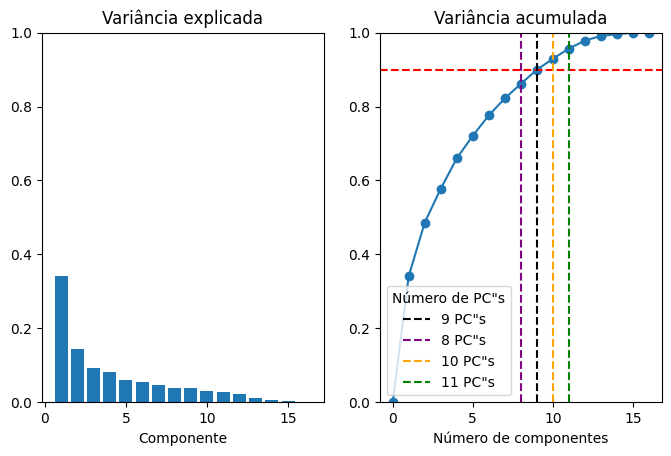

In [24]:
autovalores_gamma_norm, autovetores_gamma_norm = variancia_explicada(X_gamma_norm)

Para esse dataset conseguimos observar um comportamento diferente dos dados, quando comparamos com os outros 2 datasets. Como resultado, concluímos que <b>9 componentes principais</b> são necessárias para obter toda a informação do dataset.

In [25]:
#montando a matriz loading 

matriz_gamma_norm_loading = autovetores_gamma_norm

feature_names = X_gamma_norm.columns

nomes_componentes = [f"PC{i+1}" for i in range(X_gamma_norm.shape[1])]

df_matriz_loading_gamma_norm = pd.DataFrame(
    matriz_gamma_norm_loading,
    columns=nomes_componentes,
    index=feature_names,
)

df_matriz_loading_gamma_norm

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Status,0.091073,-0.061205,-0.075954,-0.045951,0.050560,0.045559,-0.038971,-0.040468,0.076429,-0.034146,-0.021535,-0.003640,0.025293,-0.980099,-0.059681,0.003335
Adult Mortality,0.236396,-0.252089,0.180039,0.410512,0.033416,0.243504,-0.047151,-0.156057,-0.130488,-0.220320,-0.724112,0.031380,0.011668,0.039759,-0.005010,-0.003674
infant deaths,0.239065,0.516759,0.101383,0.023329,0.132689,0.017816,-0.136144,-0.265025,-0.164251,-0.157024,0.095668,-0.000327,0.025509,-0.006248,0.001508,-0.704847
Alcohol,-0.247883,0.148177,0.333163,0.266945,-0.018318,0.035305,0.050933,0.367048,-0.637932,0.395889,0.014020,-0.027565,-0.085472,-0.152004,-0.017752,-0.008493
percentage expenditure,-0.195281,0.167405,0.224356,0.127777,-0.533094,-0.250218,0.546214,-0.437334,0.121031,0.040462,-0.083057,-0.015151,0.014192,-0.084558,0.000918,-0.001965
Measles,0.155657,0.367049,0.178873,-0.052487,0.266641,0.302821,0.450986,0.392414,0.467758,0.165823,-0.197068,-0.004580,-0.028700,0.007637,0.008048,-0.004699
BMI,-0.303848,0.081695,0.071003,-0.124696,0.150604,0.130313,-0.397311,-0.421080,0.234478,0.621825,-0.246237,-0.035096,-0.040772,0.014259,0.014349,0.001492
under-five deaths,0.244963,0.509018,0.118802,0.023577,0.133883,0.020423,-0.126840,-0.261004,-0.170173,-0.147742,0.095826,0.003978,0.027840,-0.002107,-0.010921,0.709075
Polio,-0.226529,0.122862,-0.488202,0.328305,0.204728,0.075917,0.184283,-0.108107,-0.050413,0.038036,0.021125,0.698695,-0.037598,-0.004866,0.008864,0.003920
Total expenditure,-0.161109,0.007959,0.262192,0.288978,0.419388,-0.724285,-0.129026,0.112344,0.253860,-0.133587,-0.073166,0.025896,-0.048066,-0.036469,0.005221,0.001047


#### Reduzindo dimensionalidade do dataset: `alpha_df`

In [26]:
X_alpha = alpha_df.drop(['Life expectancy '], axis=1)
y_alpha = alpha_df['Life expectancy ']

alpha_df

,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,1,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,1,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,1,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,1,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,1,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,1,44.3,723.0,27,4.36,0.000000,68.0,31,27.1,42,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,1,44.5,715.0,26,4.06,0.000000,7.0,998,26.7,41,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,1,44.8,73.0,25,4.43,0.000000,73.0,304,26.3,40,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,1,45.3,686.0,25,1.72,0.000000,76.0,529,25.9,39,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [27]:
#centralizando os dados pela média

medias_alpha = X_alpha.mean()

X_alpha_centralizado = X_alpha - medias_alpha

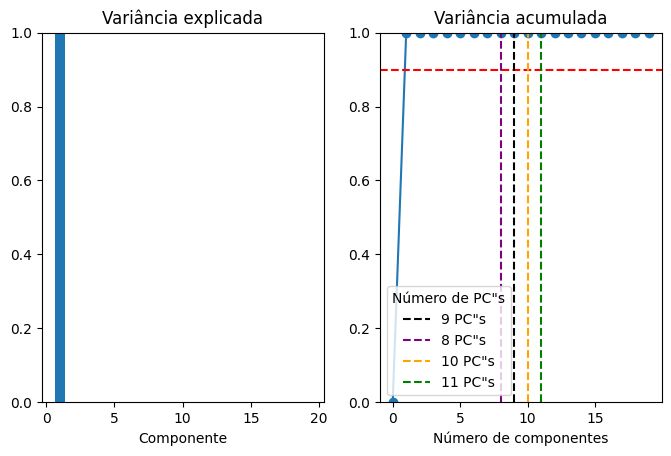

In [28]:
autovalores_a, autovatores_a = variancia_explicada(X_alpha)

Como resultado, concluímos que <b>10 componentes principais</b> são necessárias para obter o 90% da informação do dataset.

In [29]:
#montando a matriz loading 

matriz_alpha_loading = autovatores_a

feature_names = X_alpha.columns

nomes_componentes = [f"PC{i+1}" for i in range(X_alpha.shape[1])]

df_matriz_loading_alpha = pd.DataFrame(
    matriz_alpha_loading,
    columns=nomes_componentes,
    index=feature_names,
)

df_matriz_loading_alpha

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
Status,1.747743e-10,-0.000015,-9.693187e-07,-1.109076e-05,0.000235,-4.157694e-04,1.277688e-03,2.285492e-03,-6.332245e-04,-3.372155e-05,-4.602498e-03,-1.101744e-03,1.317906e-02,-3.794095e-02,-6.872967e-04,1.590916e-03,6.497441e-03,-9.991545e-01,-1.417755e-03
Adult Mortality,-2.669783e-08,-0.002706,-6.129315e-04,-7.280438e-03,0.287736,-9.548797e-01,-4.702260e-02,-4.752156e-02,4.479175e-03,-2.896608e-03,-1.151906e-02,-2.647741e-02,-1.154107e-03,2.485627e-03,1.453132e-03,3.182598e-03,-7.735900e-04,2.655205e-04,-1.387295e-04
infant deaths,1.152138e-06,-0.001295,4.030507e-03,-2.182586e-03,0.555495,1.806420e-01,-5.840432e-02,-1.791550e-02,-1.606050e-02,-3.170982e-02,-7.914499e-01,1.158538e-02,-1.569422e-01,4.343594e-02,-2.690757e-04,-2.609340e-02,-6.988915e-03,-2.234729e-04,9.594193e-04
Alcohol,-1.651480e-09,0.000153,1.666679e-05,2.662398e-04,-0.002260,1.521620e-03,-1.911811e-02,-5.645209e-02,-3.355327e-03,-1.388114e-02,1.224028e-01,5.368111e-02,-3.065927e-01,8.753624e-01,-1.109495e-01,-3.229424e-01,-4.496089e-04,-3.850784e-02,5.384397e-03
percentage expenditure,-4.192601e-07,0.144106,2.180916e-02,-9.892684e-01,-0.006429,5.521484e-03,-5.659764e-03,-1.016924e-03,4.661346e-04,7.453868e-04,-2.077148e-04,-1.975127e-04,-2.294053e-04,1.148735e-04,-2.257882e-04,2.969790e-04,-3.009826e-05,-1.062893e-05,-9.022877e-06
Hepatitis B,-4.714003e-08,0.000108,-2.158238e-04,4.330592e-03,-0.038708,9.262221e-03,-6.598721e-01,2.705055e-01,6.395496e-01,2.833313e-01,-2.814456e-03,9.569904e-03,-1.888121e-02,2.148148e-03,-5.449409e-03,-4.699399e-04,9.081857e-04,-9.720913e-04,-1.219671e-04
Measles,4.608387e-05,-0.151860,9.883781e-01,-3.020189e-04,-0.006513,-2.169042e-03,1.043445e-04,-4.936737e-05,1.113388e-04,4.364259e-05,1.865693e-04,6.494220e-06,9.808086e-05,7.350599e-06,1.362151e-05,7.543572e-06,4.018590e-06,7.785291e-07,-4.255301e-08
BMI,-2.282575e-08,0.000470,-1.755858e-04,1.888725e-03,-0.037080,3.814102e-02,-5.520844e-02,-9.228551e-01,3.396755e-01,-1.182512e-02,-2.882810e-02,3.462587e-02,1.543697e-01,-1.496954e-02,-6.999135e-03,-2.791617e-02,4.972056e-03,2.698953e-04,6.750636e-04
under-five deaths,1.522807e-06,-0.001759,5.227573e-03,-3.871307e-03,0.776430,2.291160e-01,-2.362479e-02,-1.442988e-02,2.140413e-02,2.211915e-02,5.753741e-01,-1.074481e-02,9.972116e-02,-3.662762e-02,4.829779e-04,2.052953e-02,4.880206e-03,1.426518e-04,-6.379045e-04
Polio,-1.446137e-08,0.000306,-3.920905e-05,3.601144e-03,-0.034327,2.102189e-02,-5.135343e-01,-2.158259e-01,-6.617113e-01,4.993462e-01,1.419024e-02,-8.910597e-03,8.058500e-03,-2.115866e-02,-1.592118e-03,-6.694960e-03,4.369095e-03,1.083140e-04,4.807470e-06


#### Reduzindo dimensionalidade do dataset: `beta_df`

In [30]:
X_beta = beta_df.drop(['Life expectancy '], axis=1)
y_beta = beta_df['Life expectancy ']

beta_df

,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,1,65.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,1,59.9,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,1,59.9,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,89.0,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,1,59.5,272.0,69.0,0.01,78.184215,67.0,2787.0,17.6,93.0,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,1,59.2,275.0,71.0,0.01,7.097109,68.0,3013.0,17.2,97.0,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,1,44.3,723.0,27.0,4.36,0.000000,68.0,31.0,27.1,42.0,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,1,44.5,715.0,26.0,4.06,0.000000,7.0,998.0,26.7,41.0,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,1,44.8,73.0,25.0,4.43,0.000000,73.0,304.0,26.3,40.0,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,1,45.3,686.0,25.0,1.72,0.000000,76.0,529.0,25.9,39.0,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [31]:
#centralizando os dados pela média

medias_beta = X_beta.mean()

X_beta_centralizado = X_beta - medias_beta

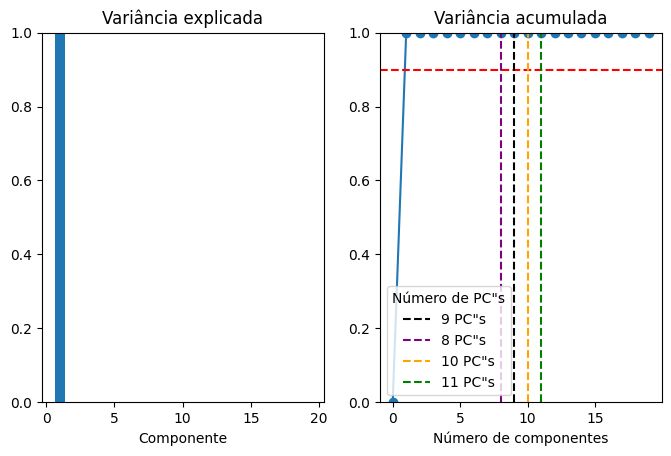

In [32]:
autovalores_b, autovatores_b = variancia_explicada(X_beta)

Como resultado, concluímos que <b>11 componentes principais</b> são necessárias para obter 90% da informação do dataset.

In [33]:
#montando a matriz loading 

matriz_beta_loading = autovatores_b

feature_names = X_beta.columns

nomes_componentes = [f"PC{i+1}" for i in range(X_beta.shape[1])]

df_matriz_loading_beta = pd.DataFrame(
    matriz_beta_loading,
    columns=nomes_componentes,
    index=feature_names,
)

df_matriz_loading_beta

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
Status,2.896947e-10,-0.000013,-8.447904e-07,5.146399e-05,0.000208,6.057819e-04,1.215758e-03,-2.081677e-03,1.691418e-03,5.078145e-05,3.574522e-03,2.127406e-02,-9.780832e-03,3.407535e-02,-6.059582e-03,6.271694e-03,2.920313e-03,-9.984338e-01,-3.625092e-02
Adult Mortality,-2.882413e-08,-0.002581,-2.595417e-04,-1.319435e-03,0.197408,9.760772e-01,-7.441469e-02,3.906955e-02,-2.660739e-02,6.708707e-04,8.199030e-03,-8.557755e-03,-1.870956e-02,-3.874751e-03,-2.277874e-03,-3.429997e-03,-2.529326e-04,3.093873e-04,-9.834944e-05
infant deaths,1.201982e-06,-0.001301,3.832620e-03,-2.674813e-03,0.575790,-1.280014e-01,-5.717942e-02,3.931005e-02,2.171279e-02,3.779664e-02,7.951260e-01,-8.946333e-02,6.120990e-02,-8.920807e-03,1.927702e-02,2.974211e-02,-5.468426e-03,-2.504304e-05,1.228134e-03
Alcohol,-2.238822e-09,0.000094,7.787076e-06,-5.210995e-04,-0.002512,-3.004306e-03,-1.777725e-02,3.844195e-02,-2.601770e-02,2.511676e-03,-8.739094e-02,-3.822388e-01,2.224839e-01,-7.970255e-01,1.133126e-01,3.804094e-01,-1.204113e-02,-3.631674e-02,-8.713308e-05
percentage expenditure,-9.104923e-07,0.131661,2.418671e-02,-9.909837e-01,-0.004831,-1.988151e-04,-2.475183e-03,-6.476724e-04,-9.082800e-04,-5.621599e-04,2.323669e-04,5.220771e-04,-3.915593e-04,3.590331e-04,-2.689059e-04,1.037204e-04,-1.465467e-05,-2.661047e-05,-6.712601e-06
Hepatitis B,-4.608866e-08,0.000114,-1.090527e-04,2.384402e-03,-0.022339,-2.009689e-02,-5.044077e-01,-6.822548e-01,-4.917399e-01,-1.899938e-01,3.034570e-02,-1.591142e-02,1.046864e-02,4.396816e-04,-5.463890e-04,-1.373584e-03,7.759749e-04,-3.660753e-04,-1.673555e-04
Measles,5.034133e-05,-0.174558,9.846225e-01,8.731277e-04,-0.006784,1.154440e-03,-1.571387e-04,1.392364e-04,-3.016305e-05,1.809160e-05,5.466243e-05,2.370141e-05,-1.017510e-05,-4.965159e-06,9.025556e-06,-5.770262e-06,2.350211e-06,7.544460e-07,-3.471037e-07
BMI,-2.341666e-08,0.000439,-1.923505e-04,8.539661e-04,-0.027749,-4.759104e-02,-1.137375e-01,6.307382e-01,-7.502103e-01,-2.434029e-02,1.067566e-02,1.473661e-01,-8.914834e-03,-2.238174e-03,1.243006e-02,2.671033e-02,2.329861e-03,5.051525e-04,6.292893e-04
under-five deaths,1.597626e-06,-0.001833,5.345894e-03,-3.965468e-03,0.791354,-1.558413e-01,-1.701548e-03,-1.748453e-02,-3.150511e-02,-2.766986e-02,-5.846900e-01,5.251870e-02,-4.289086e-02,1.228454e-02,-1.518116e-02,-2.238920e-02,3.717717e-03,-9.173524e-05,-8.499036e-04
Polio,-1.513626e-08,0.000365,-1.904098e-04,1.430603e-03,-0.027178,-4.049917e-02,-5.798830e-01,3.262344e-01,3.884272e-01,-6.348554e-01,-2.364153e-02,1.011454e-02,-7.280614e-03,1.423183e-02,6.168628e-03,7.201764e-03,1.444206e-03,-9.181957e-05,2.859604e-05


#### Reduzindo dimensionalidade do dataset: `gamma_df`

In [34]:
X_gamma = gamma_df.drop(['Life expectancy '], axis=1)
y_gamma = gamma_df['Life expectancy ']

gamma_df

,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,1,65.0,263.0,62.0,0.01,71.279624,1154.0,19.1,83.0,6.0,8.16,65.0,0.1,17.2,17.3,0.479,10.1
1,1,59.9,271.0,64.0,0.01,73.523582,492.0,18.6,86.0,58.0,8.18,62.0,0.1,17.5,17.5,0.476,10.0
2,1,59.9,268.0,66.0,0.01,73.219243,430.0,18.1,89.0,62.0,8.13,64.0,0.1,17.7,17.7,0.470,9.9
3,1,59.5,272.0,69.0,0.01,78.184215,2787.0,17.6,93.0,67.0,8.52,67.0,0.1,17.9,18.0,0.463,9.8
4,1,59.2,275.0,71.0,0.01,7.097109,3013.0,17.2,97.0,68.0,7.87,68.0,0.1,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,1,44.3,723.0,27.0,4.36,0.000000,31.0,27.1,42.0,67.0,7.13,65.0,33.6,9.4,9.4,0.407,9.2
2934,1,44.5,715.0,26.0,4.06,0.000000,998.0,26.7,41.0,7.0,6.52,68.0,36.7,9.8,9.9,0.418,9.5
2935,1,44.8,73.0,25.0,4.43,0.000000,304.0,26.3,40.0,73.0,6.53,71.0,39.8,1.2,1.3,0.427,10.0
2936,1,45.3,686.0,25.0,1.72,0.000000,529.0,25.9,39.0,76.0,6.16,75.0,42.1,1.6,1.7,0.427,9.8


In [35]:
#centralizando os dados pela média

medias_gamma = X_gamma.mean()

X_gamma_centralizado = X_gamma - medias_gamma

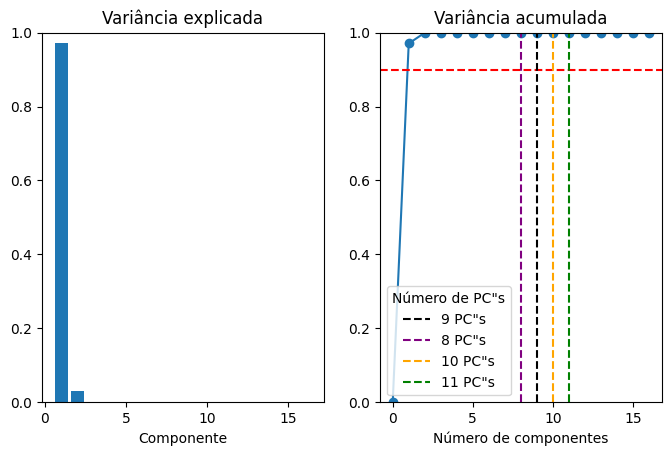

In [36]:
autovalores_g, autovatores_g = variancia_explicada(X_gamma)

Como resultado, concluímos que <b> 9 componentes principais</b> são necessárias para obter 90% da informação do dataset.

In [37]:
#montando a matriz loading 

matriz_gamma_loading = autovatores_g

feature_names = X_gamma.columns

nomes_componentes = [f"PC{i+1}" for i in range(X_gamma.shape[1])]

df_matriz_loading_gamma = pd.DataFrame(
    matriz_gamma_loading,
    columns=nomes_componentes,
    index=feature_names,
)

df_matriz_loading_gamma

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
Status,0.000003,-0.000086,0.000160,0.000646,0.001546,0.002676,-0.000083,-0.003520,0.021220,-0.009205,0.034298,-0.004313,0.006535,0.003313,-9.983254e-01,-3.924817e-02
Adult Mortality,0.000342,-0.015154,0.099139,0.990624,-0.078404,-0.043893,-0.000557,-0.008480,-0.008218,-0.018992,-0.003716,-0.002484,-0.003403,-0.000263,3.135409e-04,-9.860828e-05
infant deaths,0.005154,-0.003394,0.589595,-0.070617,-0.063674,-0.005026,-0.024022,-0.794272,-0.084768,0.057096,-0.007084,0.020927,0.029451,-0.005037,2.077328e-04,1.173820e-03
Alcohol,-0.000018,0.000664,-0.001963,-0.003381,-0.023129,-0.044780,-0.000646,0.081439,-0.382653,0.215193,-0.800912,0.109965,0.378241,-0.012518,-3.610873e-02,-2.693583e-04
percentage expenditure,-0.010156,0.999810,0.007538,0.014703,0.001369,0.001167,-0.000036,-0.000237,0.000529,-0.000257,0.000380,0.000094,0.000142,0.000011,-4.244829e-05,6.069275e-06
Measles,0.999910,0.010213,-0.008706,0.000661,-0.000205,-0.000102,-0.000007,-0.000062,0.000023,-0.000009,-0.000005,0.000009,-0.000006,0.000002,7.150457e-07,-3.619727e-07
BMI,-0.000305,0.002211,-0.020677,-0.053135,-0.168571,-0.972079,-0.006568,-0.005815,0.149135,-0.007597,0.000518,0.017112,0.026712,0.002654,4.603968e-04,6.102693e-04
under-five deaths,0.007106,-0.004770,0.800596,-0.074766,0.017257,-0.012575,0.017251,0.589637,0.049415,-0.040260,0.011340,-0.016167,-0.022160,0.003515,-2.279946e-04,-8.115266e-04
Polio,-0.000278,0.001646,-0.019457,-0.046433,-0.686147,0.118577,0.715372,0.021376,0.008000,-0.005217,0.014068,0.006974,0.007039,0.001609,-1.918870e-04,5.252449e-05
Total expenditure,-0.000022,0.000203,-0.001120,-0.001220,-0.009233,-0.019248,-0.003494,0.015593,-0.106761,0.086584,-0.113140,0.759517,-0.624623,0.018290,-1.415169e-02,-5.937691e-03


Resumindo o que concluímos com o aprendizado não supervisionado utilizando o método de redução de dimensionalidade PCA:

<b>Dataframe: norm_alpha_df</b> o número mínimo de componentes principais necessárias para se obter as informações do dataset é de 10 componentes principais.

<b>Dataframe: norm_beta_df</b> o número mínimo de componentes principais necessárias para se obter as informações do dataset é de 11 componentes principais.

<b>Dataframe: norm_gamma_df</b> o número mínimo de componentes principais necessárias para se obter as informações do dataset é de 9 componentes principais.

<b>Dataframe: alpha_df</b> o número mínimo de componentes principais necessárias para se obter as informações do dataset é de 10 componentes principais.

<b>Dataframe: beta_df</b> o número mínimo de componentes principais necessárias para se obter as informações do dataset é de 11 componentes principais.

<b>Dataframe: gamma_df</b> o número mínimo de componentes principais necessárias para se obter as informações do dataset é de 9 componentes principais.

### Redução de Datasets

In [38]:
#datasets alpha
NUM_COMP_ALPHA = 10

pca1= PCA (NUM_COMP_ALPHA)
    
X_alpha_reduzido = pca1.fit_transform(X_alpha)

X_alpha_norm_reduzido = pca1.fit_transform(X_alpha_norm)

#datasets beta
NUM_COMP_BETA = 11

pca2= PCA (NUM_COMP_BETA)

X_beta_reduzido = pca2.fit_transform(X_beta)

X_beta_norm_reduzido= pca2.fit_transform(X_beta_norm)

#datasets gamma
NUM_COMP_GAMMA = 11

pca3= PCA (NUM_COMP_GAMMA)

X_gamma_reduzido = pca3.fit_transform(X_gamma)

X_gamma_norm_reduzido = pca3.fit_transform(X_gamma_norm)

# Otimização de hiperparâmetros

Até aqui efetuamos tratamento de dados considerando:

    a) diferentes forma de lidar com dados faltantes
    
    b) possibilidade de normalização ou não,
    
E agora que já temos tantas possibilidade de dados tratados a partir de um mesmo dataset, iremos comparar seus desempenhos em diferentes modelos. Mas, um adendo importante, fixaremos aqui os hiperparâmeros para os modelos a partir de um dataset. O que isso que dizer? Teremos noção dos diferentes desempenhos de modelos e tratamentos, mas para uma análise mais precisa seria necessário que, nessa etapa, cada modelo fosse otimizado para um específico dataset, mas essa proposta fica para um leitor atento.

Dessa forma, faremos toda a parte de otimização de hiperparâmetros com o `norm_beta_df`.

## Dividindo em treino e teste e definindo constantes

Antes de podermos, de fato, perguntar a sábia entidade das tentativas, _Optuna_, sobre os melhores hiperparâmetros, vamos definir constantes, remover os NaN do target e dividir o df em treino e teste.

In [39]:
#Constantes:
NUM_FOLDS = 10        #MANTENDO O PADRÃO JÁ APLICADO (na disciplina)
TENTATIVAS = 50
SEMENTE = 2222

def divide(df):
    # Remove linhas com NaNs em qualquer lugar do DataFrame
    df = df.dropna()

    X = df.drop(['Life expectancy '], axis=1)
    y = df['Life expectancy ']

    # Loop para remover diferentes tipos de NaNs no target
    for nan_method in ['mean', 'median', 'most_frequent', 0]:
        y_finalmente = y.fillna(y.agg(nan_method))
        
        X_treino, X_teste, y_treino, y_teste = train_test_split(X, y_finalmente, test_size=0.1, random_state=SEMENTE)

        # Verifica se ainda há NaNs em y_finalmente após o preenchimento
        if y_finalmente.isnull().sum() == 0:
            break  # Sai do loop se não houver mais NaNs

    return X_treino, X_teste, y_treino, y_teste

In [40]:
X_treino_norm_beta_df, X_teste_norm_beta_df, y_treino_norm_beta_df, y_teste_norm_beta_df = divide(norm_beta_df)
#print (X_treino_norm_beta_df)

## Otimizando K-NN

Para a otimição, serão definidas funções para a aplicação do `trial`, que serão usadas para encontrar os melhores hiperparâmetros para o modelo K-NN. O mesmo será feito para a árvore de decisão e a floresta aleatória em seguida.

In [41]:
def instancia_knn(trial):
    parametros = {
        "n_neighbors" : trial.suggest_int("n_neighbors", 45, 65),  # 2939 linhas, então estamos chutando perto da raiz
        "weights" : trial.suggest_categorical('weights',[ "uniform","distance"]),
    
    }
    modelo_k = KNeighborsRegressor(**parametros)
    return modelo_k

In [42]:
#aqui criamos uma função pra computar a metrica: função objetivo

def funcao_objetivo(
    trial,
    X,
    y,
):
    
    modelo = instancia_knn(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",  ## negativo do rmse
        cv=100,
    )

    return -metricas.mean()

In [43]:
objeto_de_estudo = create_study(direction="minimize")

[I 2023-11-15 22:32:43,124] A new study created in memory with name: no-name-9fd7355a-65c8-47d7-96d7-d3a0f5f2bb7a


In [44]:
def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_treino_norm_beta_df, y_treino_norm_beta_df)

In [45]:
objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=50) # estamos usando 50 tentativas, também, porque esse valor já foi aplicado na disciplina

[I 2023-11-15 22:32:44,911] Trial 0 finished with value: 3.66265046951581 and parameters: {'n_neighbors': 56, 'weights': 'uniform'}. Best is trial 0 with value: 3.66265046951581.
[I 2023-11-15 22:32:46,223] Trial 1 finished with value: 3.416081274117864 and parameters: {'n_neighbors': 64, 'weights': 'distance'}. Best is trial 1 with value: 3.416081274117864.
[I 2023-11-15 22:32:47,360] Trial 2 finished with value: 3.70971556585403 and parameters: {'n_neighbors': 64, 'weights': 'uniform'}. Best is trial 1 with value: 3.416081274117864.
[I 2023-11-15 22:32:48,676] Trial 3 finished with value: 3.378999348404034 and parameters: {'n_neighbors': 59, 'weights': 'distance'}. Best is trial 3 with value: 3.378999348404034.
[I 2023-11-15 22:32:50,298] Trial 4 finished with value: 3.704963510576219 and parameters: {'n_neighbors': 63, 'weights': 'uniform'}. Best is trial 3 with value: 3.378999348404034.
[I 2023-11-15 22:32:51,662] Trial 5 finished with value: 3.3485296052585114 and parameters: {'n_

In [46]:
melhor_trial = objeto_de_estudo.best_trial
print(f"Parâmetros do melhor trial: {melhor_trial.params}")

Parâmetros do melhor trial: {'n_neighbors': 45, 'weights': 'distance'}


## Árvore de Decisão

Agora, encontrando os melhores hiperparâmetros para o modelo de árvore de decisão:

In [47]:
def instancia_tree(trial):
    parametros = {

        "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "poisson"]),

        "min_samples_split": trial.suggest_int("min_samples_split", 50, 500, log=True),

        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 50, 500, log=True),

        "max_features": trial.suggest_float("max_features_internal", 0, 1),

        "random_state": SEMENTE,
    }

    modelo2 = DecisionTreeRegressor(**parametros)

    return modelo2

In [48]:
def funcao_objetivo2(
    trial,
    X,
    y,
):
    
    modelo = instancia_tree(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",  ## negativo do rmse , para valer o maior melhor
        cv=50, # valor que eu escolhi e pd não dar certo
    )

    # releia sobre scores no sklearn para relembrar porque tem um negativo abaixo
    return -metricas.mean()

In [49]:
objeto_de_estudo2 = create_study(direction="minimize")

[I 2023-11-15 22:33:39,835] A new study created in memory with name: no-name-34d262f9-4dbc-4839-8a02-22056380097f


In [50]:
def funcao_objetivo_parcial2(trial):
    return funcao_objetivo2(trial, X_treino_norm_beta_df, y_treino_norm_beta_df)

In [51]:
objeto_de_estudo2.optimize(funcao_objetivo_parcial2, n_trials=50) 

[I 2023-11-15 22:33:40,996] Trial 0 finished with value: 4.670237152267018 and parameters: {'criterion': 'friedman_mse', 'min_samples_split': 342, 'min_samples_leaf': 399, 'max_features_internal': 0.9611798571686062}. Best is trial 0 with value: 4.670237152267018.
[I 2023-11-15 22:33:42,111] Trial 1 finished with value: 3.4732590984425458 and parameters: {'criterion': 'squared_error', 'min_samples_split': 275, 'min_samples_leaf': 60, 'max_features_internal': 0.9741382881353186}. Best is trial 1 with value: 3.4732590984425458.
[I 2023-11-15 22:33:42,475] Trial 2 finished with value: 5.102583918300095 and parameters: {'criterion': 'squared_error', 'min_samples_split': 120, 'min_samples_leaf': 63, 'max_features_internal': 0.0035805923008186413}. Best is trial 1 with value: 3.4732590984425458.
[I 2023-11-15 22:33:42,815] Trial 3 finished with value: 5.177535231390822 and parameters: {'criterion': 'squared_error', 'min_samples_split': 369, 'min_samples_leaf': 73, 'max_features_internal': 0.

In [52]:
melhor_trial2 = objeto_de_estudo2.best_trial
print(f"Parâmetros do melhor trial: {melhor_trial2.params}")

Parâmetros do melhor trial: {'criterion': 'squared_error', 'min_samples_split': 105, 'min_samples_leaf': 62, 'max_features_internal': 0.9966016626726908}


## Floresta

In [53]:
def instancia_forest(trial):
    parametros = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 100),

        "criterion": trial.suggest_categorical("criterion", ["squared_error", "friedman_mse", "poisson"]),

        "min_samples_split": trial.suggest_int("min_samples_split", 50, 500, log=True),

        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 50, 500, log=True),

        "max_features": trial.suggest_float("max_features_internal", 0, 1),

        "n_jobs": -1,

        "bootstrap": True,

        "random_state": SEMENTE,
    }

    modelo3 = RandomForestRegressor(**parametros)

    return modelo3


In [54]:
def funcao_objetivo3(
    trial,
    X,
    y,
):
    
    modelo = instancia_forest(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring="neg_root_mean_squared_error",  ## negativo do rmse , para valer o maior melhor
        cv=50, # valor que eu escolhi e pd não dar certo
    )

    # releia sobre scores no sklearn para relembrar porque tem um negativo abaixo
    return -metricas.mean()

In [55]:
objeto_de_estudo3 = create_study(direction="minimize")

[I 2023-11-15 22:34:40,159] A new study created in memory with name: no-name-d33cfad4-dff9-4aa0-a28f-bb73088b6b3f


In [56]:
def funcao_objetivo_parcial3(trial):
    return funcao_objetivo3(trial, X_treino_norm_beta_df, y_treino_norm_beta_df)

In [57]:
objeto_de_estudo3.optimize(funcao_objetivo_parcial3, n_trials=50) 

[I 2023-11-15 22:34:56,248] Trial 0 finished with value: 4.249718088811655 and parameters: {'n_estimators': 66, 'criterion': 'squared_error', 'min_samples_split': 98, 'min_samples_leaf': 351, 'max_features_internal': 0.5686189936503516}. Best is trial 0 with value: 4.249718088811655.
[I 2023-11-15 22:35:05,952] Trial 1 finished with value: 3.5265179659937855 and parameters: {'n_estimators': 58, 'criterion': 'squared_error', 'min_samples_split': 60, 'min_samples_leaf': 150, 'max_features_internal': 0.6235576554988267}. Best is trial 1 with value: 3.5265179659937855.
[I 2023-11-15 22:35:16,638] Trial 2 finished with value: 3.4791782103103177 and parameters: {'n_estimators': 56, 'criterion': 'friedman_mse', 'min_samples_split': 166, 'min_samples_leaf': 138, 'max_features_internal': 0.6613152324267377}. Best is trial 2 with value: 3.4791782103103177.
[I 2023-11-15 22:35:26,620] Trial 3 finished with value: 4.738917259144655 and parameters: {'n_estimators': 65, 'criterion': 'poisson', 'min_

In [58]:
melhor_trial3 = objeto_de_estudo3.best_trial
print(f"Parâmetros do melhor trial: {melhor_trial3.params}")

Parâmetros do melhor trial: {'n_estimators': 78, 'criterion': 'squared_error', 'min_samples_split': 100, 'min_samples_leaf': 55, 'max_features_internal': 0.4335986596641242}


# Treinando os modelos para cada dataset

Agora que temos os hiperparâmteros obtidos com o _Optuna_ para os 3 modelos, iremos usá-los para treinar os 6 datasets com tratamentos diferentes e avaliar o seu desempenho.
Para isso, iremos primeiramente dividir os 6 datasets em conjuntos de treino e teste, usando a função `divide`, que foi definida anteriormente nesse notebook - lembrando que essa etapa já foi feita com o dataset eta normalizado.

In [59]:
X_treino_alpha_df, X_teste_alpha_df, y_treino_alpha_df, y_teste_alpha_df = divide(alpha_df)
X_treino_beta_df, X_teste_beta_df, y_treino_beta_df, y_teste_beta_df = divide(beta_df)
X_treino_gamma_df, X_teste_gamma_df, y_treino_gamma_df, y_teste_gamma_df = divide(gamma_df)
X_treino_norm_gamma_df, X_teste_norm_gamma_df, y_treino_norm_gamma_df, y_teste_norm_gamma_df = divide(norm_gamma_df)
X_treino_norm_alpha_df, X_teste_norm_alpha_df, y_treino_norm_alpha_df, y_teste_norm_alpha_df = divide(norm_alpha_df)

## K-NN

Enfim, iremos treinar o modelo k-NN para os seis datasets que temos e comparar o RMSE desse modelo.

In [60]:
modelo_melhor = instancia_knn(melhor_trial)
modelo_melhor.fit(X_treino_norm_beta_df, y_treino_norm_beta_df)


def treina_knn(X_treino, X_teste, y_treino, y_teste):
    # Crie e treine o modelo k-NN
    modelo = modelo_melhor
    modelo.fit(X_treino, y_treino)
    
    # Faça previsões nos dados de teste
    y_verdadeiro = y_teste
    y_pred = modelo.predict(X_teste)
    
    # Avalie a precisão do modelo usando RMSE
    RMSE = mean_squared_error(y_teste, y_pred, squared=False)
        
    return y_verdadeiro, y_pred, RMSE

y_vdd_alpha, y_alpha, rmse_alpha = treina_knn(X_treino_alpha_df, X_teste_alpha_df, y_treino_alpha_df, y_teste_alpha_df)
y_vdd_beta, y_beta, rmse_beta = treina_knn(X_treino_beta_df, X_teste_beta_df, y_treino_beta_df, y_teste_beta_df)
y_vdd_gamma, y_gamma, rmse_gamma = treina_knn(X_treino_gamma_df, X_teste_gamma_df, y_treino_gamma_df, y_teste_gamma_df)
y_vdd_norm_gamma, y_norm_gamma, rmse_norm_gamma = treina_knn(X_treino_norm_gamma_df, X_teste_norm_gamma_df, y_treino_norm_gamma_df, y_teste_norm_gamma_df)
y_vdd_norm_alpha, y_norm_alpha, rmse_norm_alpha = treina_knn(X_treino_norm_alpha_df, X_teste_norm_alpha_df, y_treino_norm_alpha_df, y_teste_norm_alpha_df)
y_vdd_norm_beta, y_norm_beta, rmse_norm_beta = treina_knn(X_treino_norm_beta_df, X_teste_norm_beta_df, y_treino_norm_beta_df, y_teste_norm_beta_df)

print('O RMSE do modelo k-NN para o dataset alpha foi', rmse_alpha)
print('O RMSE do modelo k-NN para o dataset beta foi', rmse_beta)
print('O RMSE do modelo k-NN para o dataset gamma foi', rmse_gamma)
print("O RMSE do modelo k-NN para o dataset alpha normalizado foi", rmse_norm_alpha)
print("O RMSE do modelo k-NN para o dataset beta normalizado foi", rmse_norm_beta)
print("O RMSE do modelo k-NN para o dataset gamma normalizado foi", rmse_norm_gamma)

O RMSE do modelo k-NN para o dataset alpha foi 8.26622153173776
O RMSE do modelo k-NN para o dataset beta foi 7.992875888608439
O RMSE do modelo k-NN para o dataset gamma foi 4.475749231068989
O RMSE do modelo k-NN para o dataset alpha normalizado foi 3.1730261092060936
O RMSE do modelo k-NN para o dataset beta normalizado foi 3.198849772933936
O RMSE do modelo k-NN para o dataset gamma normalizado foi 3.0953357779423363


## Àrvore de Decisão

Agora, iremos treinar o modelo de árvore de decisão para os 6 datasets e comparar os valores de RMSE

In [61]:
modelo_melhor_tree = instancia_tree(melhor_trial2)
modelo_melhor_tree.fit(X_treino_norm_beta_df, y_treino_norm_beta_df)

def treina_arvore(X_treino, y_treino, X_teste, y_teste):
    # Crie e treine o modelo àrvore de decisão
    modelo = modelo_melhor_tree
    modelo.fit(X_treino, y_treino)
    
    # Faça previsões nos dados de teste
    y_verdadeiro = y_teste
    y_pred = modelo.predict(X_teste)
    
    # Avalie a precisão do modelo usando RMSE
    RMSE = mean_squared_error(y_teste, y_pred, squared=False)
        
    return y_verdadeiro, y_pred, RMSE

y_vdd_alpha_tree, y_alpha_tree, rmse_alpha_tree = treina_arvore(X_treino_alpha_df, y_treino_alpha_df, X_teste_alpha_df, y_teste_alpha_df)
y_vdd_beta_tree, y_beta_tree, rmse_beta_tree = treina_arvore(X_treino_beta_df, y_treino_beta_df, X_teste_beta_df, y_teste_beta_df)
y_vdd_gamma_tree, y_gamma_tree, rmse_gamma_tree = treina_arvore(X_treino_gamma_df, y_treino_gamma_df, X_teste_gamma_df, y_teste_gamma_df)
y_vdd_norm_alpha_tree, y_norm_alpha_tree, rmse_norm_alpha_tree = treina_arvore(X_treino_norm_alpha_df, y_treino_norm_alpha_df, X_teste_norm_alpha_df, y_teste_norm_alpha_df)
y_vdd_norm_beta_tree, y_norm_beta_tree, rmse_norm_beta_tree = treina_arvore(X_treino_norm_beta_df, y_treino_norm_beta_df, X_teste_norm_beta_df, y_teste_norm_beta_df)
y_vdd_norm_gamma_tree, y_norm_gamma_tree, rmse_norm_gamma_tree = treina_arvore(X_treino_norm_gamma_df, y_treino_norm_gamma_df, X_teste_norm_gamma_df, y_teste_norm_gamma_df)

print('O RMSE do modelo arvore de decisão para o dataset alpha foi', rmse_alpha_tree)
print('O RMSE do modelo árvore de decisão para o dataset beta foi', rmse_beta_tree)
print('O RMSE do modelo árvore de decisão para o dataset gamma foi', rmse_gamma_tree)
print("O RMSE do modelo árvore de decisão para o dataset alpha normalizado foi", rmse_norm_alpha_tree)
print("O RMSE do modelo árvore de decisão para o dataset beta normalizado foi", rmse_norm_beta_tree)
print("O RMSE do modelo árvore de decisão para o dataset gamma normalizado foi", rmse_norm_gamma_tree)

O RMSE do modelo arvore de decisão para o dataset alpha foi 2.814237405244117
O RMSE do modelo árvore de decisão para o dataset beta foi 3.261324612630214
O RMSE do modelo árvore de decisão para o dataset gamma foi 3.395559541542561
O RMSE do modelo árvore de decisão para o dataset alpha normalizado foi 2.814237405244117
O RMSE do modelo árvore de decisão para o dataset beta normalizado foi 3.2613246126302133
O RMSE do modelo árvore de decisão para o dataset gamma normalizado foi 3.395559541542561


## Floresta Aleatória

Enfim, iremos treinar o último modelo, que é a floresta aleatória.

In [62]:
modelo_melhor_forest = instancia_forest(melhor_trial3)
modelo_melhor_forest.fit(X_treino_norm_beta_df, y_treino_norm_beta_df)

#RMSE = mean_squared_error(y_verdadeiro, y_previsao, squared=False)
#print(RMSE)

def treina_floresta(X_treino, y_treino, X_teste, y_teste):
    # Crie e treine o modelo floresta aleatoria
    modelo = modelo_melhor_forest
    modelo.fit(X_treino, y_treino)
    
    # Faça previsões nos dados de teste
    y_verdadeiro = y_teste
    y_pred = modelo.predict(X_teste)
    
    # Avalie a precisão do modelo usando RMSE
    RMSE = mean_squared_error(y_teste, y_pred, squared=False)
        
    return y_verdadeiro, y_pred, RMSE

#treina_floresta(X_treino_raw_df, X_teste_raw_df, y_treino_raw_df, y_teste_raw_df)
y_vdd_alpha_forest, y_alpha_forest, rmse_alpha_forest = treina_floresta(X_treino_alpha_df, y_treino_alpha_df, X_teste_alpha_df, y_teste_alpha_df)
y_vdd_beta_forest, y_beta_forest, rmse_beta_forest = treina_floresta(X_treino_beta_df, y_treino_beta_df, X_teste_beta_df, y_teste_beta_df)
y_vdd_gamma_forest, y_gamma_forest, rmse_gamma_forest = treina_floresta(X_treino_gamma_df, y_treino_gamma_df, X_teste_gamma_df, y_teste_gamma_df)
y_vdd_norm_alpha_forest, y_norm_alpha_forest, rmse_norm_alpha_forest = treina_floresta(X_treino_norm_alpha_df, y_treino_norm_alpha_df, X_teste_norm_alpha_df, y_teste_norm_alpha_df)
y_vdd_norm_beta_forest, y_norm_beta_forest, rmse_norm_beta_forest = treina_floresta (X_treino_norm_beta_df, y_treino_norm_beta_df, X_teste_norm_beta_df, y_teste_norm_beta_df)
y_vdd_norm_gamma_forest, y_norm_gamma_forest, rmse_norm_gamma_forest = treina_floresta(X_treino_norm_gamma_df, y_treino_norm_gamma_df, X_teste_norm_gamma_df, y_teste_norm_gamma_df)


print('O RMSE do modelo floresta aleatória para o dataset alpha foi', rmse_alpha_forest)
print('O RMSE do modelo floresta aleatória para o dataset beta foi', rmse_beta_forest)
print('O RMSE do modelo floresta aleatória para o dataset gamma foi', rmse_gamma_tree)
print("O RMSE do modelo floresta aleatória para o dataset alpha normalizado foi",rmse_norm_alpha_forest )
print("O RMSE do modelo floresta aleatória para o dataset beta normalizado foi", rmse_norm_beta_forest)
print("O RMSE do modelo floresta aleatória para o dataset gamma normalizado foi", rmse_gamma_forest)

O RMSE do modelo floresta aleatória para o dataset alpha foi 2.7710618910476406
O RMSE do modelo floresta aleatória para o dataset beta foi 2.8728995783231386
O RMSE do modelo floresta aleatória para o dataset gamma foi 3.395559541542561
O RMSE do modelo floresta aleatória para o dataset alpha normalizado foi 2.7709697100721553
O RMSE do modelo floresta aleatória para o dataset beta normalizado foi 2.8727826467198447
O RMSE do modelo floresta aleatória para o dataset gamma normalizado foi 2.949235303239837


# Conclusões & Gráficos


## Normalizar ou não?

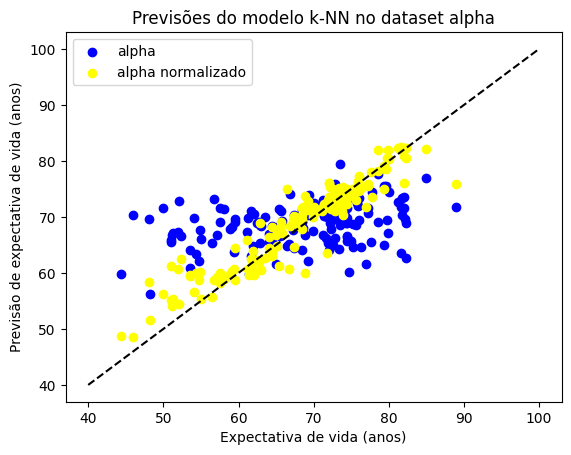

In [64]:
x = np.linspace(40, 100, 100)
 
plt.scatter(y_vdd_alpha, y_alpha, label='alpha', color='blue', marker='o')
plt.scatter(y_vdd_norm_alpha, y_norm_alpha, label='alpha normalizado', color='yellow', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo k-NN no dataset alpha')
plt.legend()
plt.show()

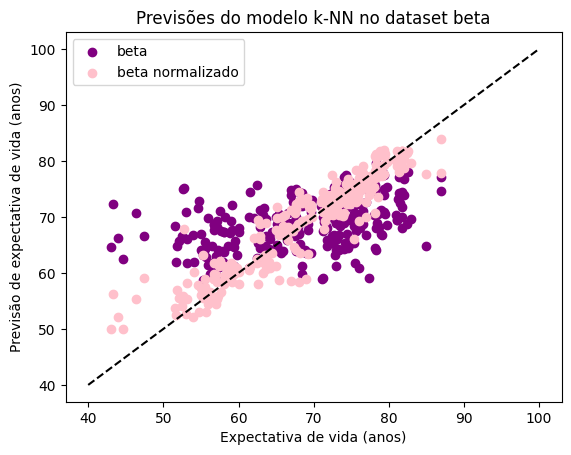

In [65]:
plt.scatter(y_vdd_beta, y_beta, label='beta', color='purple', marker='o')
plt.scatter(y_vdd_norm_beta, y_norm_beta, label='beta normalizado', color='pink', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo k-NN no dataset beta')
plt.legend()
plt.show()

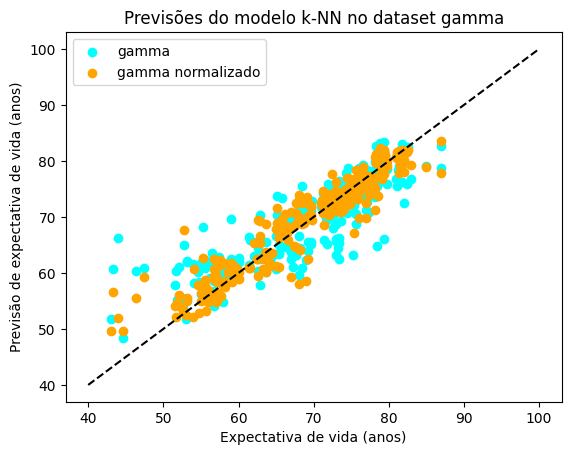

In [66]:
plt.scatter(y_vdd_gamma, y_gamma, label='gamma', color='cyan', marker='o')
plt.scatter(y_vdd_norm_gamma, y_norm_gamma, label='gamma normalizado', color='orange', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo k-NN no dataset gamma')
plt.legend()
plt.show()

#### Àrvore

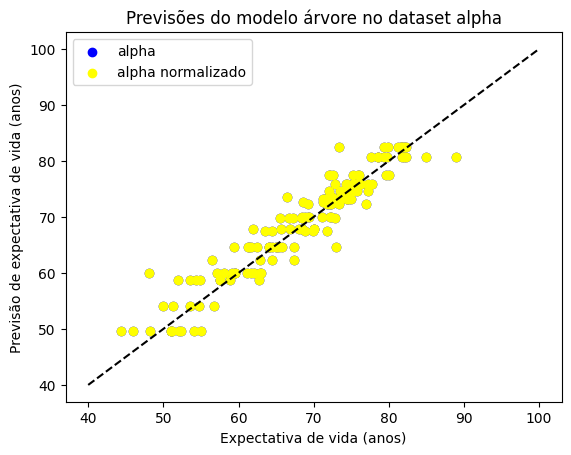

In [67]:
plt.scatter(y_vdd_alpha_tree, y_alpha_tree, label='alpha', color='blue', marker='o')
plt.scatter(y_vdd_norm_alpha_tree, y_norm_alpha_tree, label='alpha normalizado', color='yellow', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo árvore no dataset alpha')
plt.legend()
plt.show()

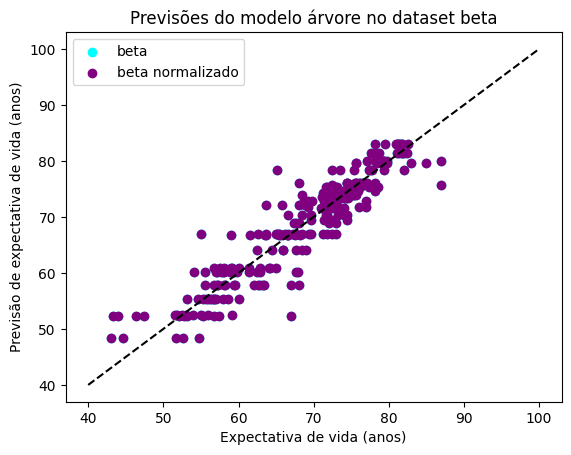

In [91]:
plt.scatter(y_vdd_beta_tree, y_beta_tree, label='beta', color='cyan', marker='o')
plt.scatter(y_vdd_norm_beta_tree, y_norm_beta_tree, label='beta normalizado', color='purple', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo árvore no dataset beta')
plt.legend()
plt.show()

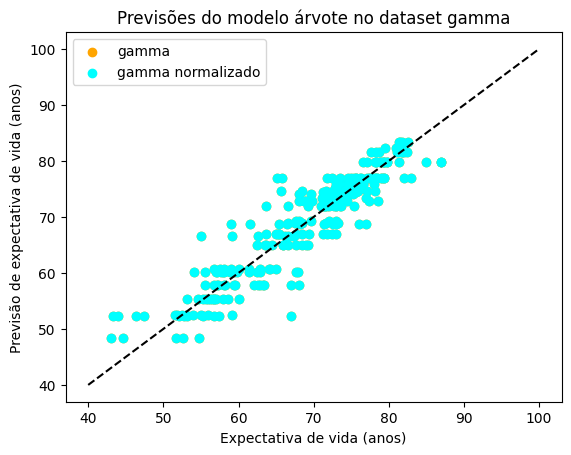

In [96]:
plt.scatter(y_vdd_gamma_tree, y_gamma_tree, label='gamma', color='orange', marker='o')
plt.scatter(y_vdd_norm_gamma_tree, y_norm_gamma_tree, label='gamma normalizado', color='cyan', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo árvote no dataset gamma')
plt.legend()
plt.show()

### Floresta

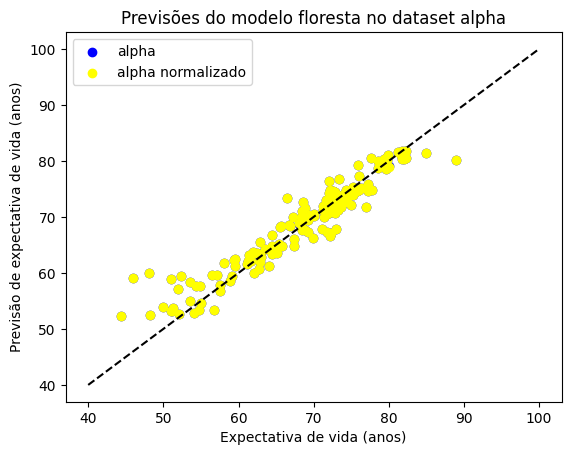

In [92]:
plt.scatter(y_vdd_alpha_forest, y_alpha_forest, label='alpha', color='blue', marker='o')
plt.scatter(y_vdd_norm_alpha_forest, y_norm_alpha_forest, label='alpha normalizado', color='yellow', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo floresta no dataset alpha')
plt.legend()
plt.show()

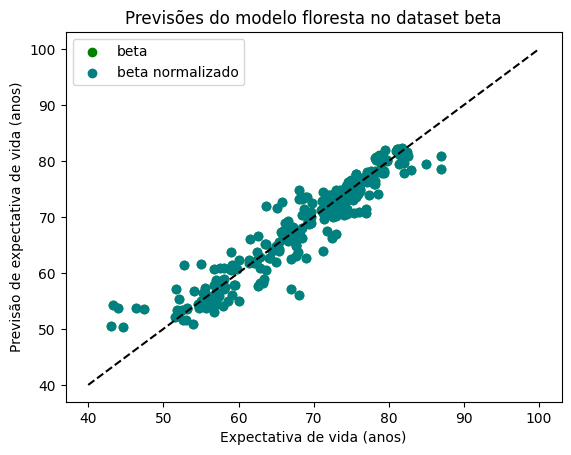

In [93]:
plt.scatter(y_vdd_beta_forest, y_beta_forest, label='beta', color='green', marker='o')
plt.scatter(y_vdd_norm_beta_forest, y_norm_beta_forest, label='beta normalizado', color='teal', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo floresta no dataset beta')
plt.legend()
plt.show()

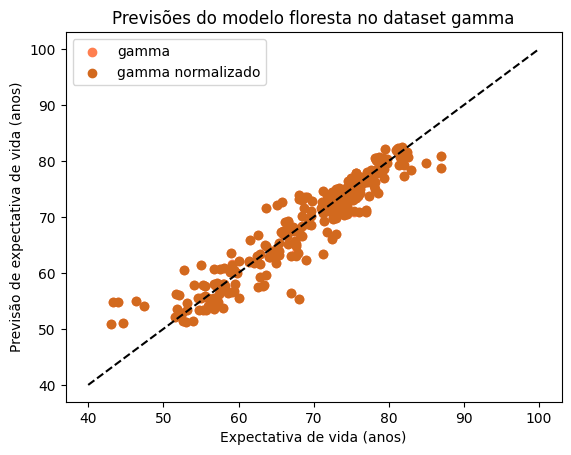

In [95]:
plt.scatter(y_vdd_gamma_forest, y_gamma_forest, label='gamma', color='coral', marker='o')
plt.scatter(y_vdd_norm_gamma_forest, y_norm_gamma_forest, label='gamma normalizado', color='chocolate', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo floresta no dataset gamma')
plt.legend()
plt.show()

## Melhor preenchimento de valores NaN?

Vamos trabalhar apenas com os dados normalizados aqui, ok?

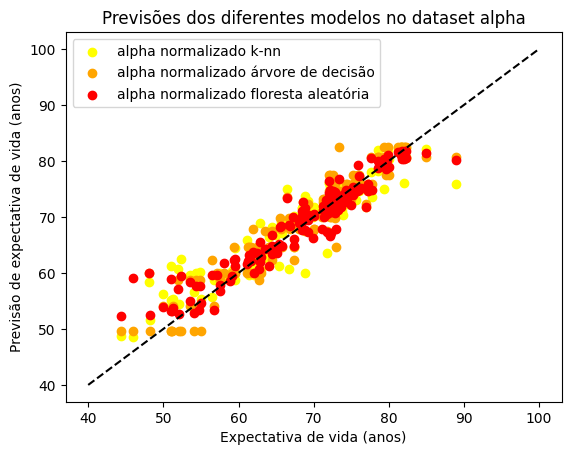

In [99]:
plt.scatter(y_vdd_norm_alpha, y_norm_alpha, label='alpha normalizado k-nn', color='yellow', marker='o')
plt.scatter(y_vdd_norm_alpha_tree, y_norm_alpha_tree, label='alpha normalizado árvore de decisão', color='orange', marker='o')
plt.scatter(y_vdd_norm_alpha_forest, y_norm_alpha_forest, label='alpha normalizado floresta aleatória', color='red', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões dos diferentes modelos no dataset alpha')
plt.legend()
plt.show()

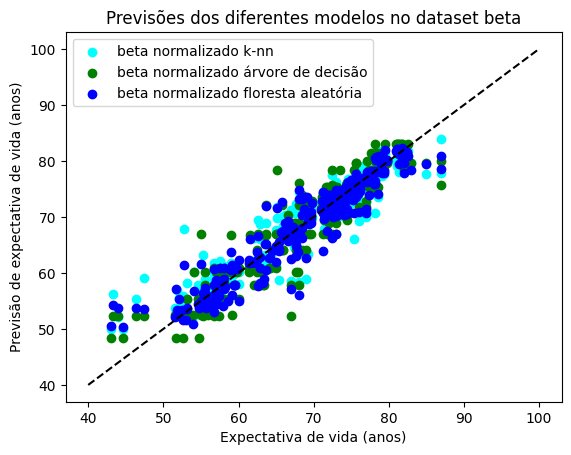

In [98]:
plt.scatter(y_vdd_norm_beta, y_norm_beta, label='beta normalizado k-nn', color='cyan', marker='o')
plt.scatter(y_vdd_norm_beta_tree, y_norm_beta_tree, label='beta normalizado árvore de decisão', color='green', marker='o')
plt.scatter(y_vdd_norm_beta_forest, y_norm_beta_forest, label='beta normalizado floresta aleatória', color='blue', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões dos diferentes modelos no dataset beta')
plt.legend()
plt.show()

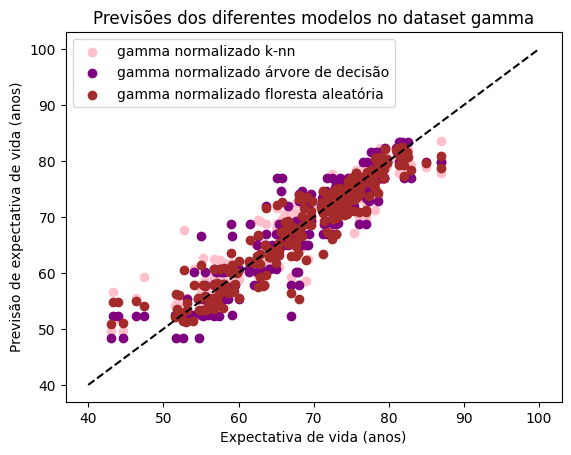

In [97]:
plt.scatter(y_vdd_norm_gamma, y_norm_gamma, label='gamma normalizado k-nn', color='pink', marker='o')
plt.scatter(y_vdd_norm_gamma_tree, y_norm_gamma_tree, label='gamma normalizado árvore de decisão', color='purple', marker='o')
plt.scatter(y_vdd_norm_gamma_forest, y_norm_gamma_forest, label='gamma normalizado floresta aleatória', color='brown', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões dos diferentes modelos no dataset gamma')
plt.legend()
plt.show()

## Qual o melhor modelo?

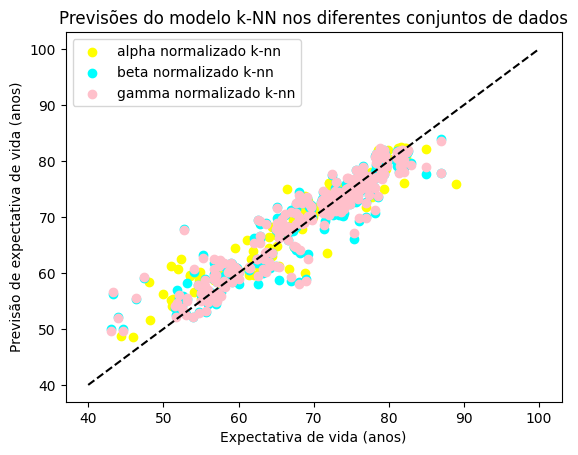

In [83]:
plt.scatter(y_vdd_norm_alpha, y_norm_alpha, label='alpha normalizado k-nn', color='yellow', marker='o')
plt.scatter(y_vdd_norm_beta, y_norm_beta, label='beta normalizado k-nn', color='cyan', marker='o')
plt.scatter(y_vdd_norm_gamma, y_norm_gamma, label='gamma normalizado k-nn', color='pink', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo k-NN nos diferentes conjuntos de dados')
plt.legend()
plt.show()

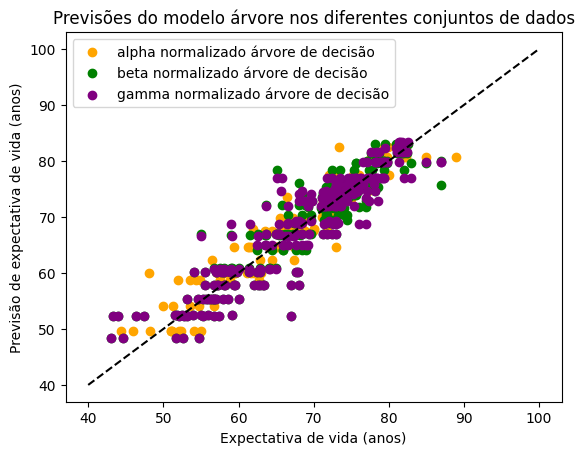

In [84]:
plt.scatter(y_vdd_norm_alpha_tree, y_norm_alpha_tree, label='alpha normalizado árvore de decisão', color='orange', marker='o')
plt.scatter(y_vdd_norm_beta_tree, y_norm_beta_tree, label='beta normalizado árvore de decisão', color='green', marker='o')
plt.scatter(y_vdd_norm_gamma_tree, y_norm_gamma_tree, label='gamma normalizado árvore de decisão', color='purple', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo árvore nos diferentes conjuntos de dados')
plt.legend()
plt.show()

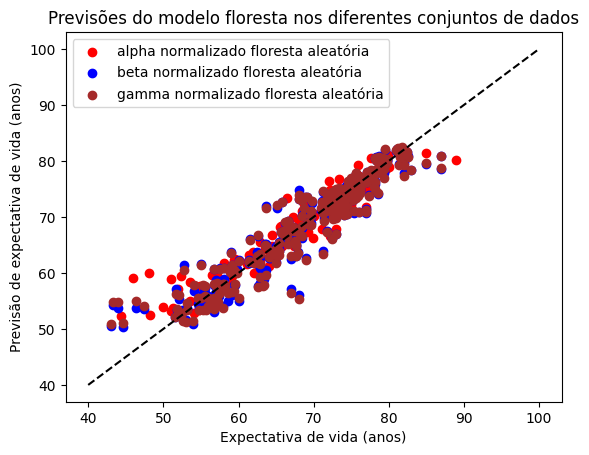

In [85]:
plt.scatter(y_vdd_norm_alpha_forest, y_norm_alpha_forest, label='alpha normalizado floresta aleatória', color='red', marker='o')
plt.scatter(y_vdd_norm_beta_forest, y_norm_beta_forest, label='beta normalizado floresta aleatória', color='blue', marker='o')
plt.scatter(y_vdd_norm_gamma_forest, y_norm_gamma_forest, label='gamma normalizado floresta aleatória', color='brown', marker='o')
plt.plot(x, x, color='black', linestyle='--')  # Linha diagonal representando previsões perfeitas
plt.xlabel('Expectativa de vida (anos)')
plt.ylabel('Previsão de expectativa de vida (anos)')
plt.title('Previsões do modelo floresta nos diferentes conjuntos de dados')
plt.legend()
plt.show()

## Conclusão:

Nesse ponto podemos observar que o melor resultado, com base no RMSE, foi obtido com o datset alpha pelo método da floresta aleatória, independente da normalização - dado que a normalização não afeta os resultados de modelos como árvore de decisão e floresta aleatória. Ao citar a normalização, seu impacto só é efetivo no modelo de k-nn, uma vez que ele envolve atribuição de pesos às distâncias entre os pontos, o que não acontece nos outros.

Quanto aos métodos de tratamento de dados faltantes, não houve varição de mais de 2 anos na previsão final, o que não significou grande discrepância;  já quanto à escolha dos modelos, o único que apresentou um RMSE maior que 4 anos foi o K-NN no contexto sem normalização, os demais tiveram um desempenho muito parecido.

Por fim, salientamos que seria oportuno um novo estudo com hiperparâmetros normalizados para cada dataet.



# Referências

[1] Cassar, Daniel Roberto. Módulos da disciplina de Aprendizado de Máquina.


[2][Como preencher dados NaN com o SimpleImputer](https://medium.com/data-hackers/tratamento-e-transforma%C3%A7%C3%A3o-de-dados-nan-uma-vis%C3%A3o-geral-e-pr%C3%A1tica-54efa9fc7a98)

[3] [Scikit-learn - K Neighbors Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)


[4] [Scikit-learn - Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)


[3] [Scikit-learn - Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)